# Data Exploration

Answers questions about *why* certain things were done to the data in the pre-processing stage.

In [122]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
from read_data import read_datasets
from data_cleaning import _make_cols_uniform

all_data = read_datasets()
processed = [
    _make_cols_uniform(df) for df in all_data
]

data = pd.concat(processed, ignore_index=True)


In [124]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300


## Log-transformation

The features Power Efficiency and Rmax are both log-transformed in the actual code, but do they follow an exponential trend in the first place?

In [125]:
# Change these values
x_var = "Date"  # The dataset the system appeared in (will repeat same system)
# x_var = "Year"  # Year of installation/last major update
# y_var = "Rmax [TFlop/s]"
y_var = "Power Efficiency [GFlops/Watts]"

if y_var == "Rmax [TFlop/s]":
    log_y_var = "Log(Rmax)"
else:
    log_y_var = "Log(Efficiency)"


Lin:  0.8672653170728992
Quad: 0.9721045958922023
Exp:  0.9855772778953811


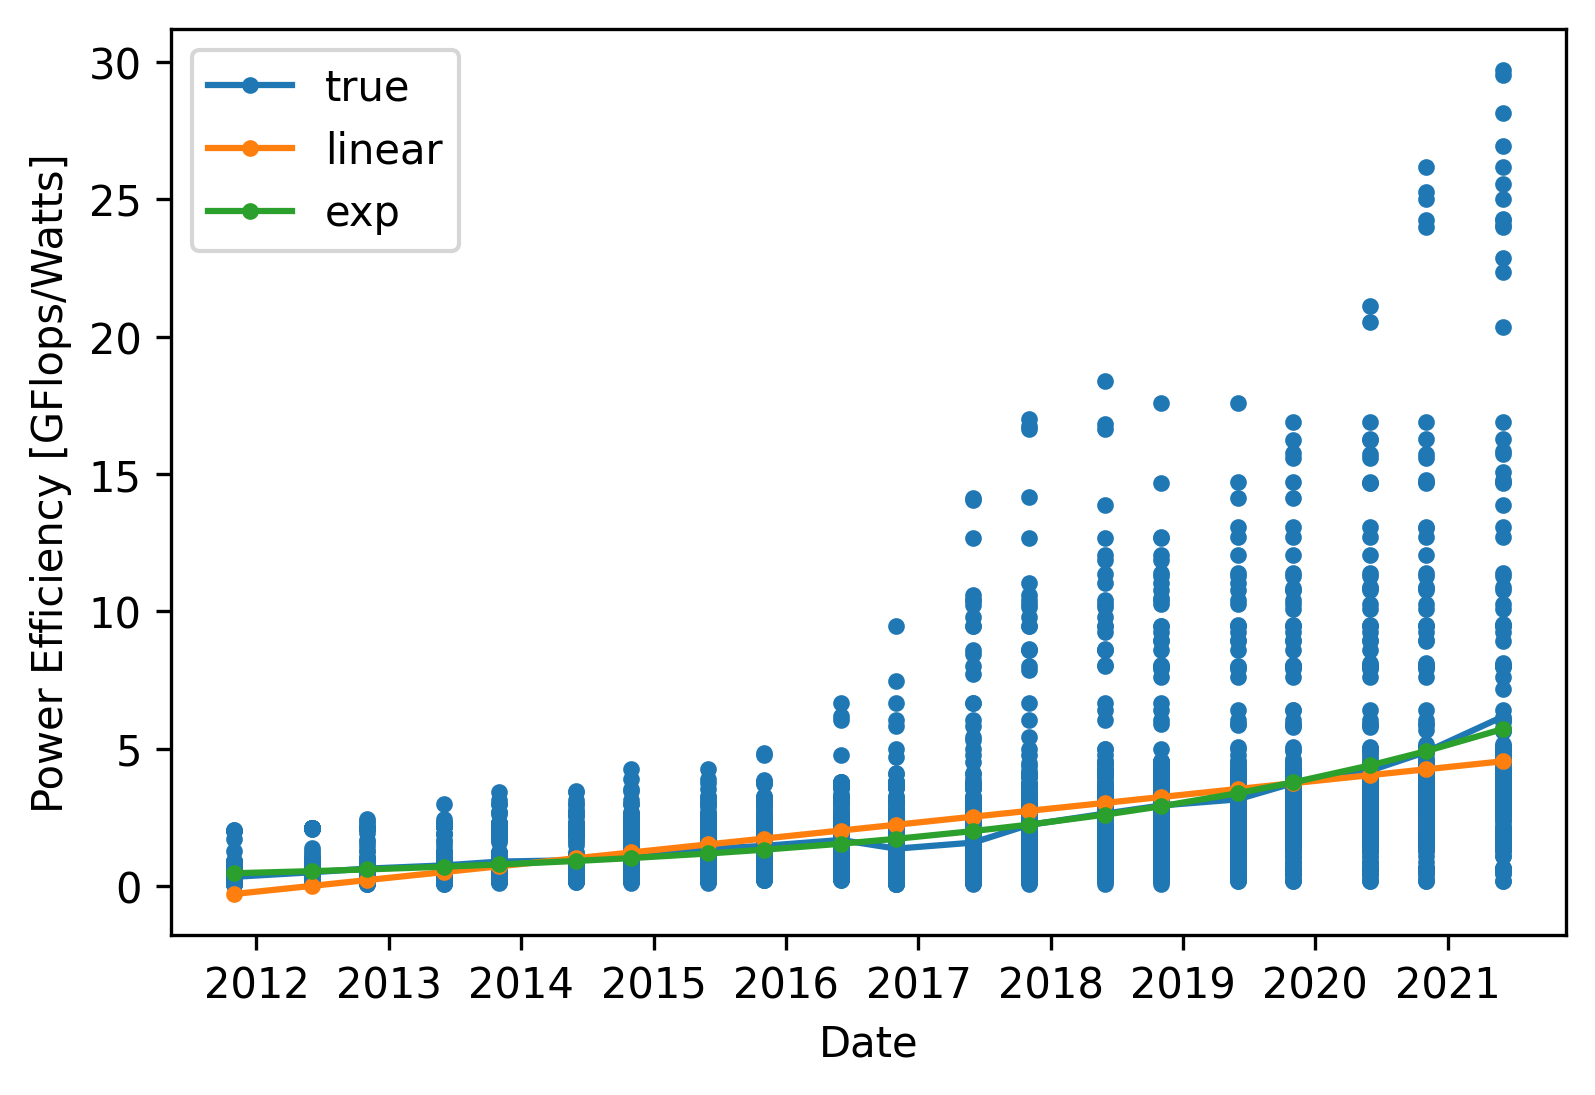

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

data = data.dropna(subset=[y_var])

by_date = data.groupby(by=x_var).mean()
y = by_date[y_var]
x = by_date.index.values.astype("datetime64[D]").astype(np.int64)

plt.scatter(data[x_var], data[y_var], marker=".")
plt.plot(by_date.index, y, marker=".", label="true")
plt.xlabel("Date")
plt.ylabel(y_var)
if y_var == "Rmax [TFlop/s]":
    plt.ylim((0, 21000))

# Linear fit
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b
lin_r2 = r2_score(y, y_pred)
plt.plot(x, y_pred, marker=".", label="linear")

# Exponential fit
y_log = np.log(y)
m, b = np.polyfit(x, y_log, 1, w=np.sqrt(y))
y_pred = np.exp(m * x + b)
exp_r2 = r2_score(y, y_pred)
plt.plot(x, y_pred, marker=".", label="exp")

# Quadratic fit
a, b, c = np.polyfit(x, y, 2)
y_pred = a * (x ** 2) + b * x + c
quad_r2 = r2_score(y, y_pred)
# plt.plot(x, y_pred, marker=".", label="quad")

plt.legend()

print(f"Lin:  {lin_r2}")
print(f"Quad: {quad_r2}")
print(f"Exp:  {exp_r2 }")


Lin: 0.9600027194148696


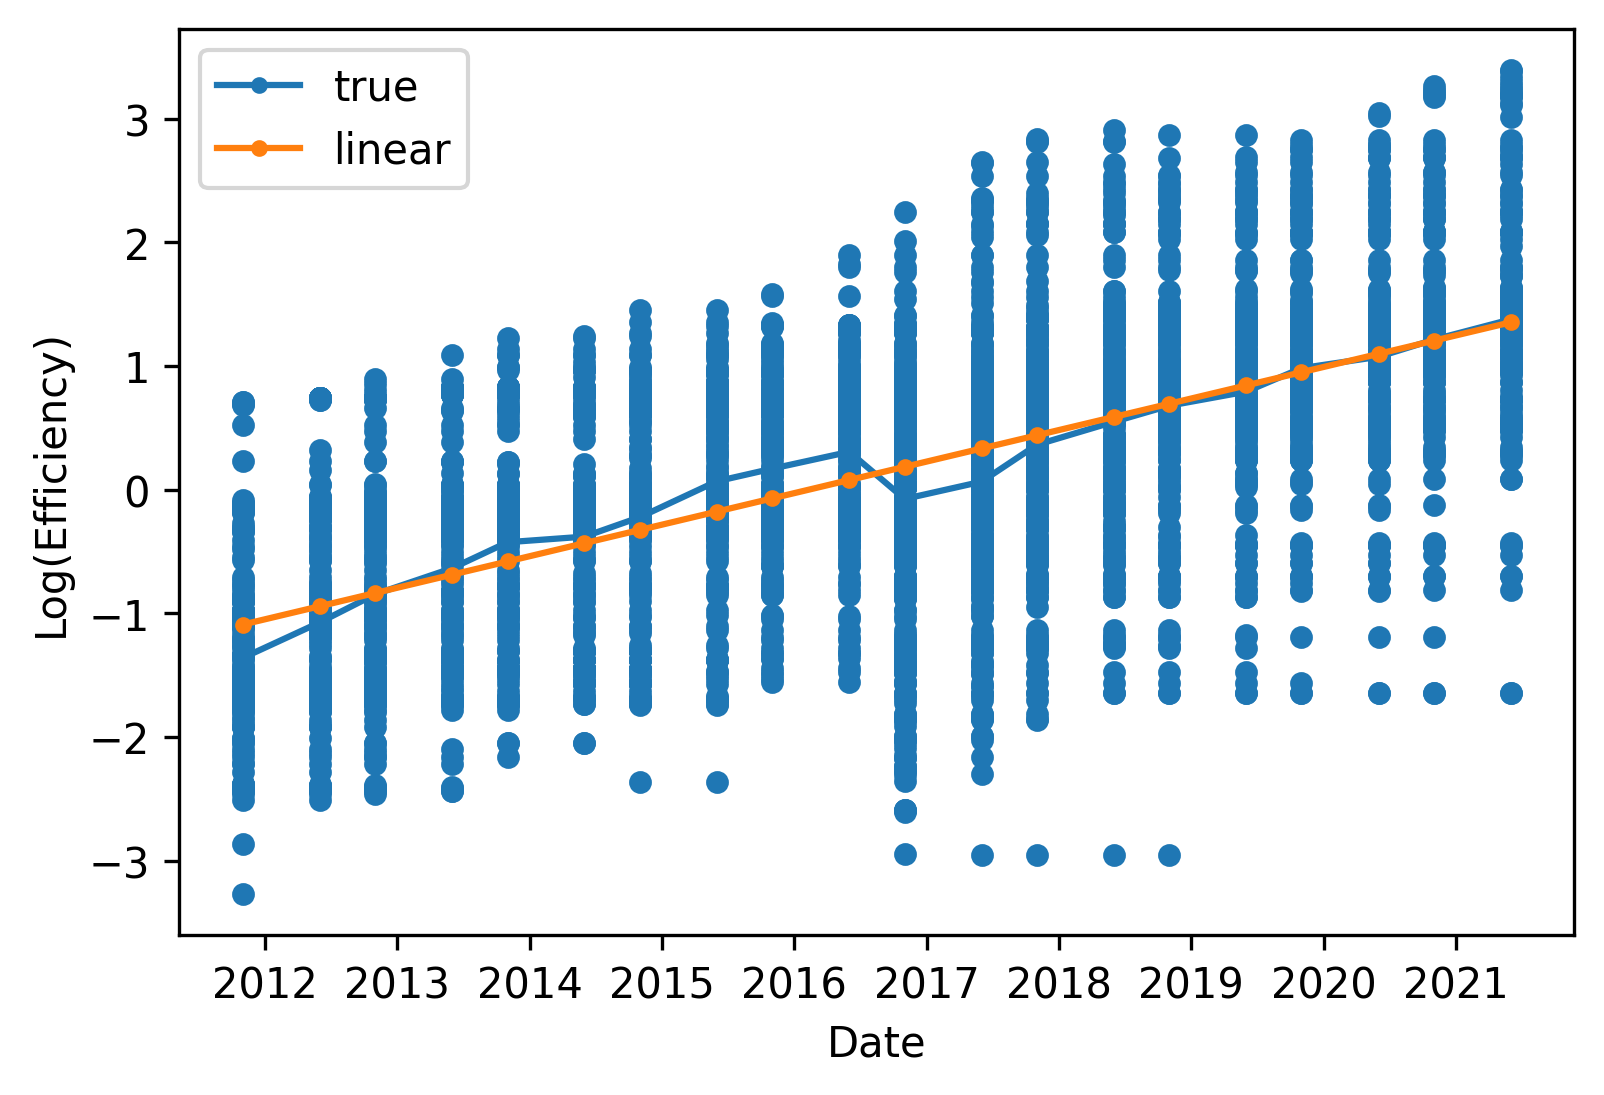

In [127]:
from data_cleaning import _apply_log_transforms

log_data = _apply_log_transforms(data)
log_data.plot.scatter(x_var, log_y_var)

log_by_date = log_data.groupby(by=x_var).mean()
x = log_by_date.index.values.astype("datetime64[D]").astype(np.int64)
log_y = log_by_date[log_y_var]
plt.plot(x, log_y, marker=".", label="true")

# Linearity
m, b = np.polyfit(x, log_y, 1)
log_y_pred = m * x + b
log_r2 = r2_score(log_y, log_y_pred)
plt.plot(x, log_y_pred, marker=".", label="linear")

plt.legend()

print(f"Lin: {log_r2}")


## Co-Processor Cores

How large is the number of co-processor cores? If it is large, what can we do to limit its range for better model performance?

Text(0, 0.5, 'Co-Processor Cores')

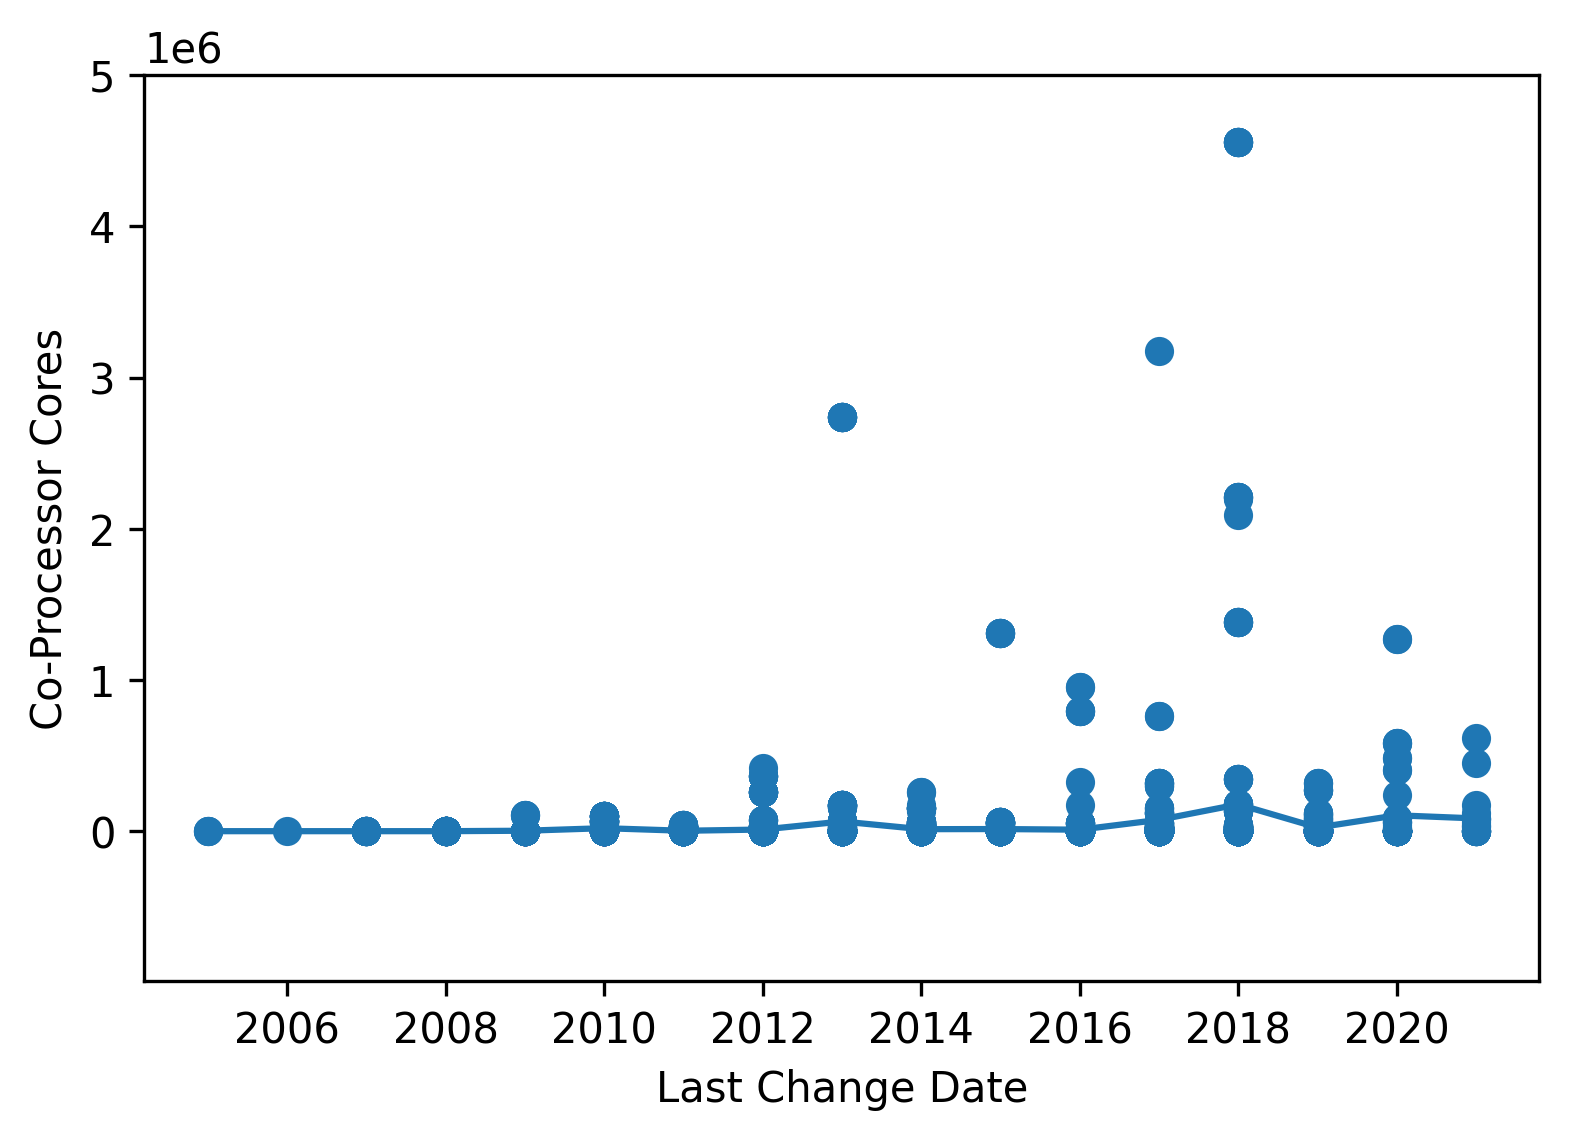

In [128]:
x_var = "Year"
y_var = "Accelerator/Co-Processor Cores"

by_date = data.groupby(by=x_var).mean()
x = by_date.index.values.astype("datetime64[D]").astype(np.int64)
y = by_date[y_var]

plt.scatter(data[x_var], data[y_var])
plt.plot(x, y, marker=".")
plt.ylim(top=0.5*(10**7))
plt.xlabel("Last Change Date")
plt.ylabel("Co-Processor Cores")


<AxesSubplot:xlabel='Year', ylabel='Co-Processor Cores to Total Cores'>

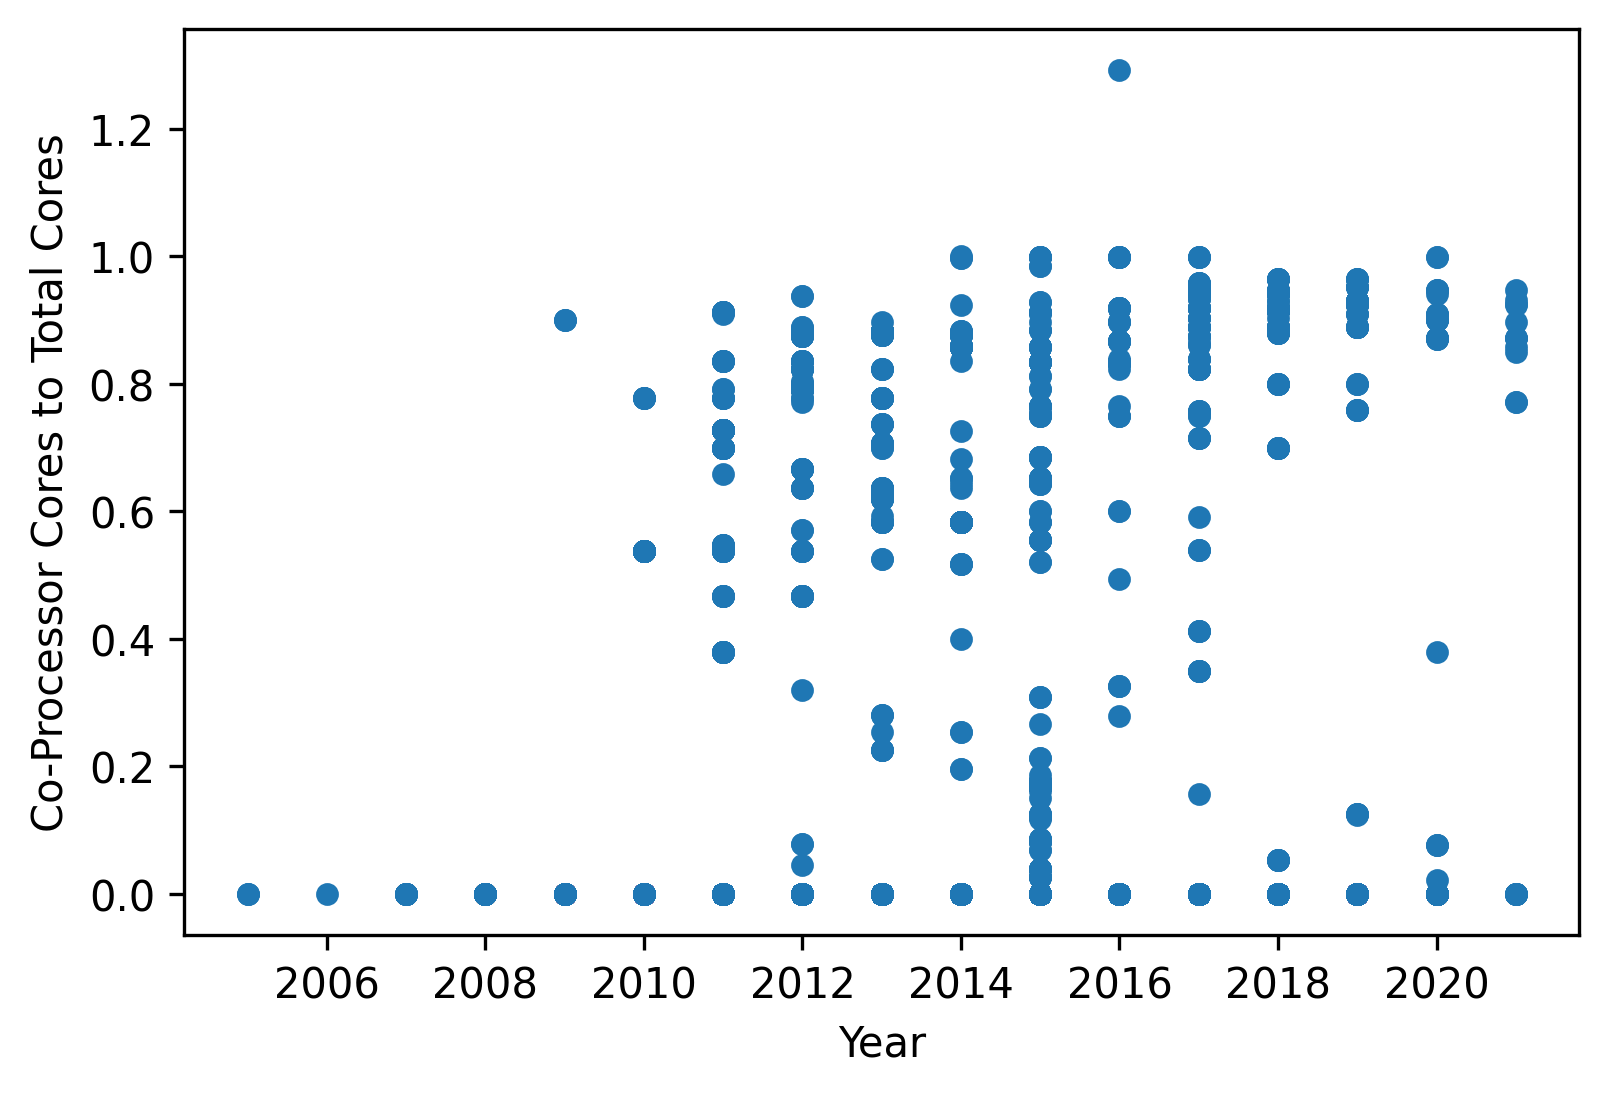

In [129]:
from data_cleaning import _create_coprocessor_ratio_col

data = _create_coprocessor_ratio_col(data)

data.plot.scatter("Year", "Co-Processor Cores to Total Cores")


## Microarchitecture

Is it worth creating a Microarchitecture feature by hand when TOP500 includes a Processor Technology column? How good is the hand-rolled column?

In [130]:
from read_data import read_valid_microarchitectures

processor_tech_vals = data["Processor Technology"].unique()
print("Number processor technology values:", processor_tech_vals.size)

microarch_vals = read_valid_microarchitectures()
print("Number microarchitecture values:", len(microarch_vals))

processor_vals = data.Processor.unique()
print("Number processor values:", processor_vals.size)


Number processor technology values: 27
Number microarchitecture values: 46
Number processor values: 272


In [131]:
from data_cleaning import _create_microarchitecture_col

data = _create_microarchitecture_col(data)

num_unknown = (data["Microarchitecture"].values == "Unknown").sum()
print(f"Number unknown: {num_unknown}")


Number unknown: 0


In [132]:
print(f"Total number of rows: {len(data.index)}")

Total number of rows: 5332
